In [16]:
import datetime
import pandas as pd
import matplotlib as mpl

In [17]:
%matplotlib inline
mpl.style.use('classic')

# Clean PISCES data

PISCE: https://academic.oup.com/bioinformatics/article/19/12/1589/258419

PISCES datasets are composed of lists of PDB accession numbers and chain identifiers which have been curated to to contain chains that are relatively non-redundant (percent identity), of particular resolution cutoffs, and composed of X-ray, cryo-electron microscopy, and/or NMR structures.  These are used here to limit the content of the downloaded, .csv transformed, and cleaned secondary structure information from RCSB-PDB (ss.txt and ss.cleaned.csv).

In [18]:
# Change the filename to refer to the specific cullpdb* file of interest
# with appropriate cutoff criteria

pisces_df = pd.read_csv('./raw_data/cullpdb_pc30.0_res0.0-2.5_len40-10000_R0.3_Xray_d2022_07_23_chains15023.gz',  sep=r'[\t ]+', engine='python')

In [19]:
pisces_df.head(2)

,PDBchain,len,method,resol,rfac,freerfac
0,5D8VA,83,XRAY,0.48,0.072,0.078
1,3NIRA,46,XRAY,0.48,0.127,NaN


In [20]:
pisces_df.shape

(15023, 6)

**Note that in the original dataset from 2018, the column names were:***

```IDs length Exptl. resolution R-factor FreeRvalue```

**The following code has been changed to refer to the new column names shown above.***

In [21]:
# make sure IDs values are all unique
assert pisces_df.PDBchain.unique().shape[0] == pisces_df.shape[0]

In [22]:
%%time
# For explanantion of chain code: http://dunbrack.fccc.edu/Guoli/pisces_download.php
pdb_id_chain_ids = pisces_df.PDBchain.apply(
    lambda s: pd.Series([s, s[:4], s[4]], index=['PDBchain', 'pdb_id', 'chain_code']))

CPU times: user 2.89 s, sys: 28.5 ms, total: 2.92 s
Wall time: 2.92 s


In [23]:
pdb_id_chain_ids.head()

# The column name PDBchain was previously IDs

,PDBchain,pdb_id,chain_code
0,5D8VA,5D8V,A
1,3NIRA,3NIR,A
2,5NW3A,5NW3,A
3,1UCSA,1UCS,A
4,3X2MA,3X2M,A


In [24]:
# replaced PDBchain column with (pdb_id, chain_code) columns
out_df = pisces_df.merge(pdb_id_chain_ids, on='PDBchain').drop('PDBchain', axis=1)

In [25]:
out_df.head()

,len,method,resol,rfac,freerfac,pdb_id,chain_code
0,83,XRAY,0.48,0.072,0.078,5D8V,A
1,46,XRAY,0.48,0.127,NaN,3NIR,A
2,54,XRAY,0.59,0.135,0.146,5NW3,A
3,64,XRAY,0.62,0.139,0.155,1UCS,A
4,180,XRAY,0.64,0.122,0.129,3X2M,A


# Intersect with pdb

In [29]:
%%time
adf = pd.read_csv('./raw_data/2022-08-03-ss.cleaned.csv', dtype=str)

CPU times: user 2.81 s, sys: 218 ms, total: 3.03 s
Wall time: 3.09 s


In [30]:
adf['len'] = adf['len'].astype(int)

In [31]:
adf.shape

(477153, 7)

In [32]:
adf.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


In [33]:
%time bdf = adf.merge(out_df, on=['pdb_id', 'chain_code'])

CPU times: user 132 ms, sys: 9.99 ms, total: 142 ms
Wall time: 141 ms


In [34]:
bdf.shape

(13406, 12)

In [35]:
bdf.head(2)

,pdb_id,chain_code,seq,sst8,sst3,len_x,has_nonstd_aa,len_y,method,resol,rfac,freerfac
0,1VZJ,A,DTLDEAERQWKAEFHRWSSYMVHWKNQFDHYSKQDRCSDL,CCCTTHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCC,CCCCCHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCC,40,False,40,XRAY,2.35,0.247,0.259
1,2D7D,B,KERQKVVEQMEHEMKEAAKALDFERAAELRDLLLELKAEG,CHHHHHHHHHHHHHHHHHHTTCHHHHHHHHHHHHHHHCCC,CHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHCCC,40,False,40,XRAY,2.10,0.230,0.285


In [36]:
bdf.describe()

,len_x,len_y,resol,rfac,freerfac
count,13406.000000,13406.000000,13406.000000,13406.000000,13294.000000
mean,266.052663,266.052514,1.773668,0.183289,0.215845
std,162.381686,162.381244,0.374467,0.030760,0.035827
min,40.000000,40.000000,0.480000,0.050000,0.078000
25%,147.000000,147.000000,1.500000,0.164000,0.192000
50%,233.000000,233.000000,1.800000,0.184000,0.217000
75%,344.000000,344.000000,2.002000,0.204000,0.241000
max,2128.000000,2128.000000,2.500000,0.299000,0.369000


### Check that lengths from PDB ss.txt and cullpdb match

In [49]:
bdf.query('len_x != len_y')

,pdb_id,chain_code,seq,sst8,sst3,len_x,has_nonstd_aa,len_y,method,resol,rfac,freerfac
4822,6SLL,A,WSHPQFEKSGMAVDTGTEVVYRRPEARDGTRVWELIRDTGSLDLNS...,CCCCCCCCCCCCCCCCCCCEEECCCGGGHHHHHHHHHHHSSSCCCC...,CCCCCCCCCCCCCCCCCCCEEECCCHHHHHHHHHHHHHHCCCCCCC...,180,False,186,XRAY,1.20,0.123,0.150
6581,6L27,A,MGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIS...,CCGGGGSSCEEEEEEEEEEETTEEEEEEEEEEEEGGGTEEEEEEEE...,CCHHHHCCCEEEEEEEEEEECCEEEEEEEEEEEEHHHCEEEEEEEE...,229,False,227,XRAY,0.77,0.119,0.124
7053,3NED,A,MGHHHHHHGVSKGEEDNMAIIKEFMRFKTHMEGSVNGHEFEIEGEG...,CCCCCCCCCCCCCCHHHHHHSCSSEEEEEEEEEEETTEEEEEEEEE...,CCCCCCCCCCCCCCHHHHHHCCCCEEEEEEEEEEECCEEEEEEEEE...,244,False,242,XRAY,0.95,0.135,0.157
9062,6YB7,A,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,CCCCCCCCCCHHHHTTEEEEEETTEEEEEEEETTEEEEEGGGGCCT...,CCCCCCCCCCHHHHCCEEEEEECCEEEEEEEECCEEEEEHHHHCCC...,306,False,305,XRAY,1.25,0.144,0.180
9672,1OEW,A,STGSATTTPIDSLDDAYITPVQIGTPAQTLNLDFDTGSSDLWVFSS...,CCEEEEEEESSTTCCCEEEEEEETTTTEEEEEEEETTCCCEEECBT...,CCEEEEEEECCCCCCCEEEEEEECCCCEEEEEEEECCCCCEEECEC...,330,False,329,XRAY,0.90,0.121,0.147
12455,1GKM,A,TELTLKPGTLTLAQLRAIHAAPVRLQLDASAAPAIDASVACVEQII...,CEEEECTTCCCHHHHHHHHHSCCEEEECGGGHHHHHHHHHHHHHHH...,CEEEECCCCCCHHHHHHHHHCCCEEEECHHHHHHHHHHHHHHHHHH...,509,False,507,XRAY,1.00,0.119,0.135


#### They don't match, so check which (if either) is correct

In [50]:
q = bdf.query('len_x != len_y')

print("seq = ", [len(s) for s in q.seq])
print("sst8 = ", [len(s) for s in q.sst8])
print('sst3 = ', [len(s) for s in q.sst3])

seq =  [180, 229, 244, 306, 330, 509]
sst8 =  [180, 229, 244, 306, 330, 509]
sst3 =  [180, 229, 244, 306, 330, 509]


PDB ss.txt is accurate, which is consistent with the original dataset findings from 2018.

Original note:

Verified that the `ss.txt.gz` from pdb is more update-to-date (see [fasta](https://www.rcsb.org/pdb/download/viewFastaFiles.do?structureIdList=5LTR&compressionType=uncompressed)), so drop `length` column

<AxesSubplot:ylabel='Frequency'>

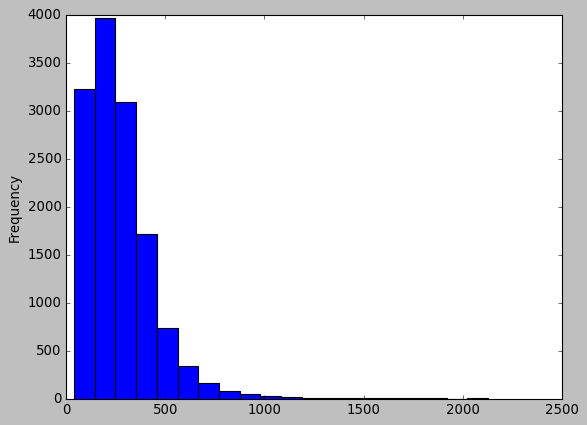

In [52]:
bdf.len_x.plot.hist(bins=20)

In [53]:
bdf.head(2)

,pdb_id,chain_code,seq,sst8,sst3,len_x,has_nonstd_aa,len_y,method,resol,rfac,freerfac
0,1VZJ,A,DTLDEAERQWKAEFHRWSSYMVHWKNQFDHYSKQDRCSDL,CCCTTHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCC,CCCCCHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCC,40,False,40,XRAY,2.35,0.247,0.259
1,2D7D,B,KERQKVVEQMEHEMKEAAKALDFERAAELRDLLLELKAEG,CHHHHHHHHHHHHHHHHHHTTCHHHHHHHHHHHHHHHCCC,CHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHCCC,40,False,40,XRAY,2.10,0.230,0.285


# Get a sense of sst distribution

In [54]:
sst8_sr = pd.Series(list(''.join(bdf.sst8.values.tolist())))

<AxesSubplot:>

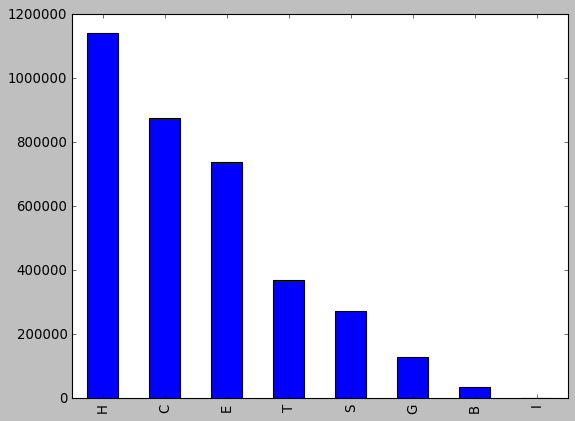

In [55]:
sst8_sr.value_counts().plot.bar()

In [56]:
sst3_sr = pd.Series(list(''.join(bdf.sst3.values.tolist())))

<AxesSubplot:>

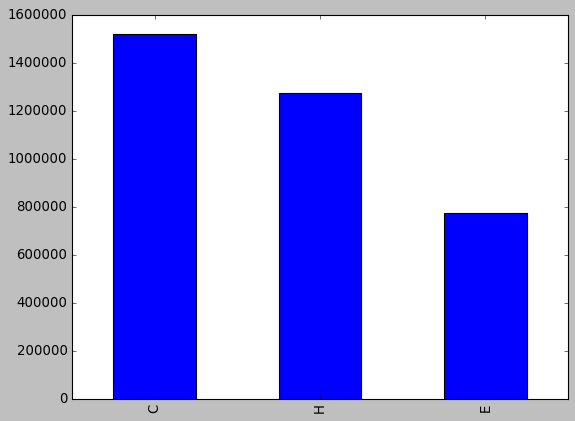

In [57]:
sst3_sr.value_counts().plot.bar()

# Get a sense of aa distribution

In [58]:
aa_sr = sst_sr = pd.Series(list(''.join(bdf.seq.values.tolist())))

<AxesSubplot:>

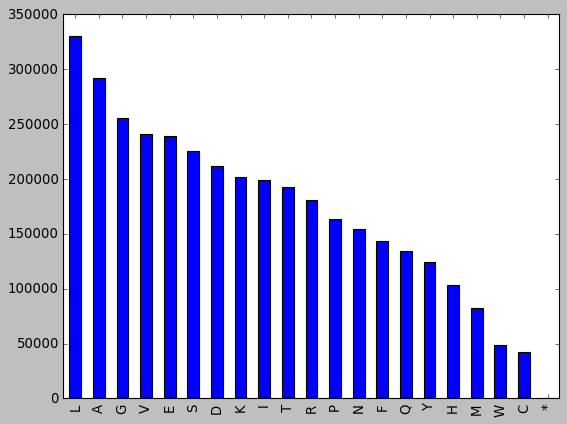

In [59]:
aa_sr.value_counts().plot.bar()

In [31]:
bdf.to_csv('.raw_data/2022-08-06-pdb-intersect-pisces_pc30_r2.5.csv', index=False)